In [1]:
import mlflow
from camelyon.log_ops import TRACKING_URI
mlflow.set_tracking_uri(TRACKING_URI)

model = mlflow.pytorch.load_model("file:///vast/AI_team/mlflow_artifact/25/9a4bc3564ed94ccb8aa2be11e65f837f/artifacts/model")
model = model.eval().to("cuda")

/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from camelyon.trainer import ImageTrainer
from camelyon.datasets import SlideDataset

transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 기준 (변경 가능)
              std=[0.229, 0.224, 0.225]),
    ])

test_dataset = SlideDataset(
    os.path.join("/vast/AI_team/dataset/CAMELYON16/patch/20x_h5", "test"),
    transform=transform,
    device="cuda",
)

xs, y = test_dataset[0]

In [ ]:
import tqdm
with torch.no_grad():
    res = list()
    for x in tqdm.tqdm(xs):
        logit = model(x.view(1, 3, 224,224).to("cuda"))
        res.append(logit)

logits = torch.concat(res)
torch.sigmoid(logits.max())

100%|██████████| 7640/7640 [00:43<00:00, 176.42it/s]


In [23]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from camelyon.trainer import ImageTrainer
from camelyon.datasets import SlideDataset


transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 기준 (변경 가능)
              std=[0.229, 0.224, 0.225]),
    ])

test_dataset = SlideDataset(
    os.path.join("/vast/AI_team/dataset/CAMELYON16/patch/20x_h5", "test"),
    transform=transform,
    device="cuda",
)
test_dataloader = DataLoader(
    test_dataset, 
    shuffle=True, 
    num_workers=8,
    prefetch_factor=4,
)
trainer = ImageTrainer(
    model=model,
    loss=torch.nn.BCEWithLogitsLoss(),
)
metrics = trainer.test(test_dataloader, use_mlflow=False)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f39bea07f70>
Traceback (most recent call last):
  File "/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/heon/anaconda3/envs/camelyon/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f39bea07f70>
Traceback (most recent call last):
  File "/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/heon/anaconda3/envs/camelyon/lib/python

In [27]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

print(roc_auc_score(metrics.labels, metrics.probs))
precision, recall, _ = precision_recall_curve(metrics.labels, metrics.probs)
print(auc(recall, precision))


0.8612244897959184
0.8483881436023486


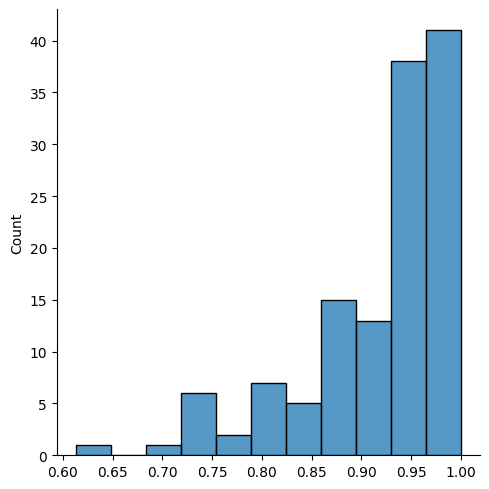

In [29]:
import seaborn as sns

sns.displot(metrics.probs)

In [3]:
import os
import h5py

path = "/vast/AI_team/dataset/CAMELYON16/feature/resnet50_3rd_20x_h5/train/tumor_111.h5"

with h5py.File(path, 'r') as fh:
    for key in fh.keys():
        print(key)
        


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/vast/AI_team/dataset/CAMELYON16/feature/resnet50_3rd_20x_h5/train/tumor_111.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)